In [2]:
import tensorflow as tf

In [3]:
!unzip drive/My\ Drive/dataset/fruits.zip > /dev/null

In [4]:
base_dir = '/fruits-360/'

In [5]:
import pathlib
train_dir = pathlib.Path("/content/fruits-360/Training")
test_dir = pathlib.Path("/content/fruits-360/Test")

In [6]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

67692

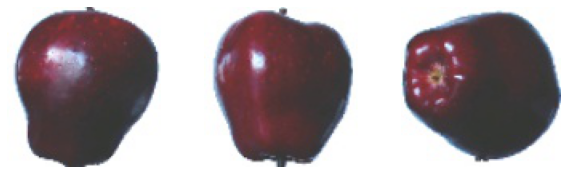

In [7]:
import PIL
import matplotlib.pyplot as plt
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [8]:
batch_size = 32
img_height = 100
img_width = 100

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)

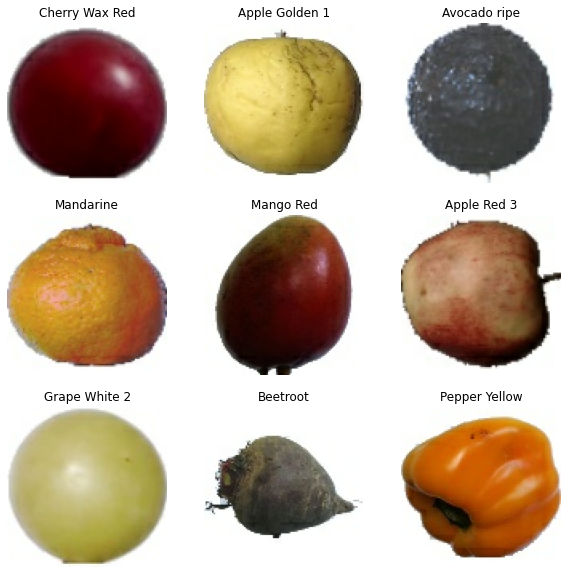

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [16]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [20]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [23]:
model.evaluate(val_ds)

424/424 [==============================] - 49s 40ms/step - loss: 6.3930 - accuracy: 0.0013


[6.392801761627197, 0.0012557245790958405]

In [24]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
1693/1693 [==============================] - 117s 56ms/step - loss: 1.2984 - accuracy: 0.7170 - val_loss: 0.2864 - val_accuracy: 0.9661
Epoch 2/10
1693/1693 [==============================] - 90s 53ms/step - loss: 0.2185 - accuracy: 0.9596 - val_loss: 0.1136 - val_accuracy: 0.9890
Epoch 3/10
1693/1693 [==============================] - 89s 53ms/step - loss: 0.1055 - accuracy: 0.9824 - val_loss: 0.0631 - val_accuracy: 0.9946
Epoch 4/10
1693/1693 [==============================] - 90s 53ms/step - loss: 0.0635 - accuracy: 0.9901 - val_loss: 0.0404 - val_accuracy: 0.9966
Epoch 5/10
1693/1693 [==============================] - 90s 53ms/step - loss: 0.0420 - accuracy: 0.9936 - val_loss: 0.0296 - val_accuracy: 0.9975
Epoch 6/10
1693/1693 [==============================] - 90s 53ms/step - loss: 0.0303 - accuracy: 0.9955 - val_loss: 0.0206 - val_accuracy: 0.9989
Epoch 7/10
1693/1693 [==============================] - 90s 53ms/step - loss: 0.0227 - accuracy: 0.9967 - val_loss: 0.0165 

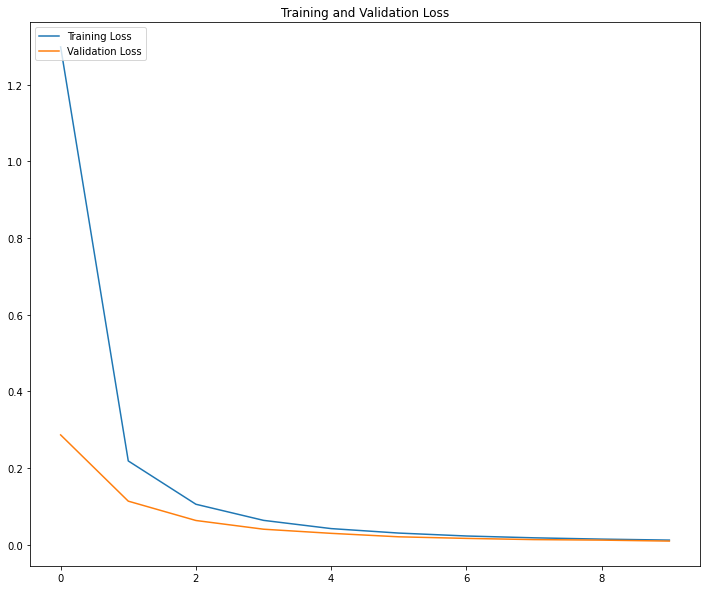

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [26]:
model.save("Fruits_model_new.hdf5")

In [48]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg -O demo.jpg

--2021-05-20 15:31:08--  https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2085213 (2.0M) [image/jpeg]
Saving to: ‘demo.jpg’

demo.jpg            100%[===================>]   1.99M  11.0MB/s    in 0.2s    

2021-05-20 15:31:09 (11.0 MB/s) - ‘demo.jpg’ saved [2085213/2085213]



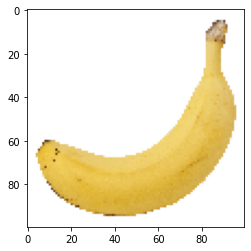

In [49]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

x = image.load_img('demo.jpg',target_size=(100, 100, 3))
plt.imshow(x)

In [50]:
x =image.img_to_array(x)
x.shape

(100, 100, 3)

In [51]:
x = x.reshape(1,100,100,3)
x.shape

(1, 100, 100, 3)

In [52]:
from keras.applications.resnet50 import preprocess_input
import numpy as np

In [55]:
x = preprocess_input(x)
y =model.predict(x)

In [56]:
y = np.argmax(y)
y

16

In [57]:
class_names[y]

'Banana'